<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C5/C5.html"><img src="../data/C5_nav.png" width="100"  style="float:right;" alt="C5"></a>
<h1>HMM-Based Chord Recognition</h1> 
</div>

<br/>

<p>
Following Section 5.3.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook an HMM-based approach for chord recognition. The idea of using HMMs for chord recognition was originally introduced by Sheh and Ellis. 
<ul>

<li><span style="color:black">
Alexander Sheh, Daniel P. W. Ellis: <strong>Chord segmentation and recognition using EM-trained hidden Markov models.</strong> Proceedings of the International Conference on Music Information Retrieval (ISMIR), Baltimore, 2003. 
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_ShehE03_Chord_ISMIR.txt"> Bibtex </a>
</span></li>
    
<li><span style="color:black">
Taemin Cho, Juan Pablo Bello: <strong>On the Relative Importance of Individual Components of Chord Recognition Systems.</strong> IEEE/ACM Transactions on Audio, Speech, and Language Processing, 22 (2014), pp. 466&ndash;492. 
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_ChoB14_Chord_IEEE-TASLP.txt"> Bibtex </a>
</span></li>
    
<li><span style="color:black">
Nanzhu Jiang, Peter Grosche, Verena Konz, Meinard Müller: <strong>Analyzing Chroma Feature Types for Automated Chord Recognition.</strong> Proceedings of the AES Conference on Semantic Audio, Ilmenau, Germany, 2011. 
<br>    
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_JiangGKM11_Chord_AES.txt"> Bibtex </a>
</span></li>


    
</ul>    
        
    
</p> 

## Introduction

We now show how the concept of [HMMs](../C5/C5S3_HiddenMarkovModel.html) can be applied to improve [automated chord recognition](../C5/C5S2_ChordRec_Templates.html). First of all, we need to create an HMM that suitably models our chord recognition problem. Generally, as introduced in the [FMP noteboook on HMMs](../C5/C5S3_HiddenMarkovModel.html), an HMM is specified by the parameters $\Theta:=(\mathcal{A},A,C,\mathcal{B},B)$. In the chord recognition context, the set 

$$
\mathcal{A}:=\{\alpha_{1},\alpha_{2},\ldots,\alpha_{I}\}.
$$

of states is used to model the various chord types that are allowed in the recognition problem. As in the [FMP notebook on template-based chord recognition](../C5/C5S2_ChordRec_Templates.html), we consider in this notebook only the twelve major and twelve minor triads, thus setting

\begin{equation}
\label{eq:ChordReco:HMM:App:Spec:SetStates}
  \mathcal{A} = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{Cm^\sharp},\ldots,\mathbf{Bm}\} 
\end{equation}

In this case, the HMM consists of $I=24$ states, which we enumerate as indicated above. For example, $\alpha_{1}$ corresponds to $\mathbf{C}$ and  $\alpha_{13}$ to $\mathbf{Cm}$. In the remainder of this notebook, we do the following: 

* First, we explain how to explicitly create an HMM by specifying the other HMM parameters in a musically informed fashion. Even though these parameters may be learned automatically from training data using the [Baum&ndash;Welch Algorithm](../C5/C5S3_HiddenMarkovModel.html), the manual specification of HMM parameters is instructive and leads to an HMM with an explicit musical meaning. 

* Second, we apply this HMM for chord recognition. The input (i.e., observation sequence) of the HMM is a  [**chromagram representation**](../C3/C3S1_SpecLogFreq-Chromagram.html) of the music recording. Applying the [**Viterbi Algorithm**](../C5/C5S3_Viterbi.html), we then derive an optimal state sequence (consisting of chord labels) that best explains the chroma sequence. The sequence of chord labels yields our frame-wise chord recognition result.

We will compare the HMM-based chord recognition results with the results obtained from the [template-based approach](../C5/C5S2_ChordRec_Templates.html). In particular we will see that the HMM transition model introduces a kind of **context-aware postfiltering**. 

## Specification of Emission Likelihoods

In our chord recognition scenario, the observations are chroma vectors that have previously been extracted from the given audio recording. In other words, the observations are $12$-dimensional real-valued vectors which are elements of the continuous feature space $\mathcal{F}=\mathbb{R}^{12}$. So far, we have only considered the case of **discrete HMMs**, where the observations are discrete symbols coming from a finite output space $\mathcal{B}$. To make discrete HMMs applicable to our scenario, one possible procedure is to introduce a finite set of prototype vectors, a so-called **codebook**. Such a codebook can be regarded as a discretization of the continuous feature space $\mathcal{F}=\mathbb{R}^{12}$, where each codebook vector represents an entire range of feature vectors. Emission probabilities can then be determined on the basis of this finite set of codebook vectors.

As an alternative, we use in the following an HMM variant, where we replace the discrete output space $\mathcal{B}$ by the continuous feature space $\mathcal{F}=\mathbb{R}^{12}$ and the emission probability matrix $B$ by **likelihood functions**. In particular, the emission probability of a given state is replaced by a normalized similarity value defined as inner product of a state-dependent normalized template and a normalized observation (chroma) vector. To compute the state-dependent likelihood functions, we proceed as described in the  [FMP notebook on template-based chord recognition](../C5/C5S2_ChordRec_Templates.html). Let $s:\mathcal{F} \times \mathcal{F} \to [0,1]$ be the **similarity measure** defined by the [inner product of normalized chroma vectors](../C5/C5S2_ChordRec_Templates.html) (where one should use a [thresholded normalization](../C3/C3S1_FeatureNormalization.html) to avoid division by zero):

$$
s(x, y)  = \frac{\langle x,y\rangle}{\|x\|_2\cdot\|y\|_2}
$$ 

for $x,y\in\mathcal{F}$. Based on $I=24$ major and minor triads (encoded by the states $\mathcal{A}$ and indexed by the set $[1:I]$), we consider the [**binary chord templates**](../C5/C5S2_ChordRec_Templates.html) $\mathbf{t}_i\in \mathcal{F}$  for $i\in [1:I]$. Then, we define the state-dependent likelihood function $b_i:\mathcal{F}\to [0,1]$ by

$$
b_i(x) := \frac{s(x, \mathbf{t}_i)}{\sum_{j\in[1:I]}s(x, \mathbf{t}_j)}
$$

for $x\in\mathcal{F}$ and $i\in [1:I]$. In our scenario, the [observation sequence](../C5/C5S3_HiddenMarkovModel.html) $O=(o_{1},o_{2},\ldots,o_{N})$ is a sequence of chroma vectors $o_n\in\mathcal{F}$. We define the observation-dependent $(I\times N)$-matrix $B[O]$ by 

$$
B[O](i,n) = b_i(o_n)
$$

for $i\in[1:I]$ and $n\in[1:N]$. Note that his matrix is exactly the [**chord similarity matrix**](../C5/C5S2_ChordRec_Templates.html) with a column-wise [$\ell^1$-normalization](../C3/C3S1_FeatureNormalization.html), as introduced in the [FMP notebook on template-based chord recognition](../C5/C5S2_ChordRec_Templates.html) and visualized in form of a **time&ndash;chord representation**. In context of the the [Viterbi algorithm](../C5/C5S3_Viterbi.html), the likelihood $B[O](i,n)$ is used to replace the probability value $b_{ik_n}$. 

As our running example throughout the remainder of this notebook, we continue our Bach example introduced in the [FMP notebook on chord recognition evaluation](../C5/C5S2_ChordRec_Eval.html). In this example, we consider a piano recording of the first four measures of Johann Sebastian Bach's $\mathrm{C}$-major prelude. Furthermore, in the next code cell, we show the observation sequence $O$ (chromagram representation) as well as the likelihood matrix $B[O]$ (time&ndash;chord representation).

<img src="../data/C5/FMP_C5_F20a.png" width="500px" align="left" alt="FMP_C5_20a">

<br clear="all" />

<audio style="width: 500px;" src="../data/C5/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer.wav" type="audio/mpeg" controls="controls"></audio>

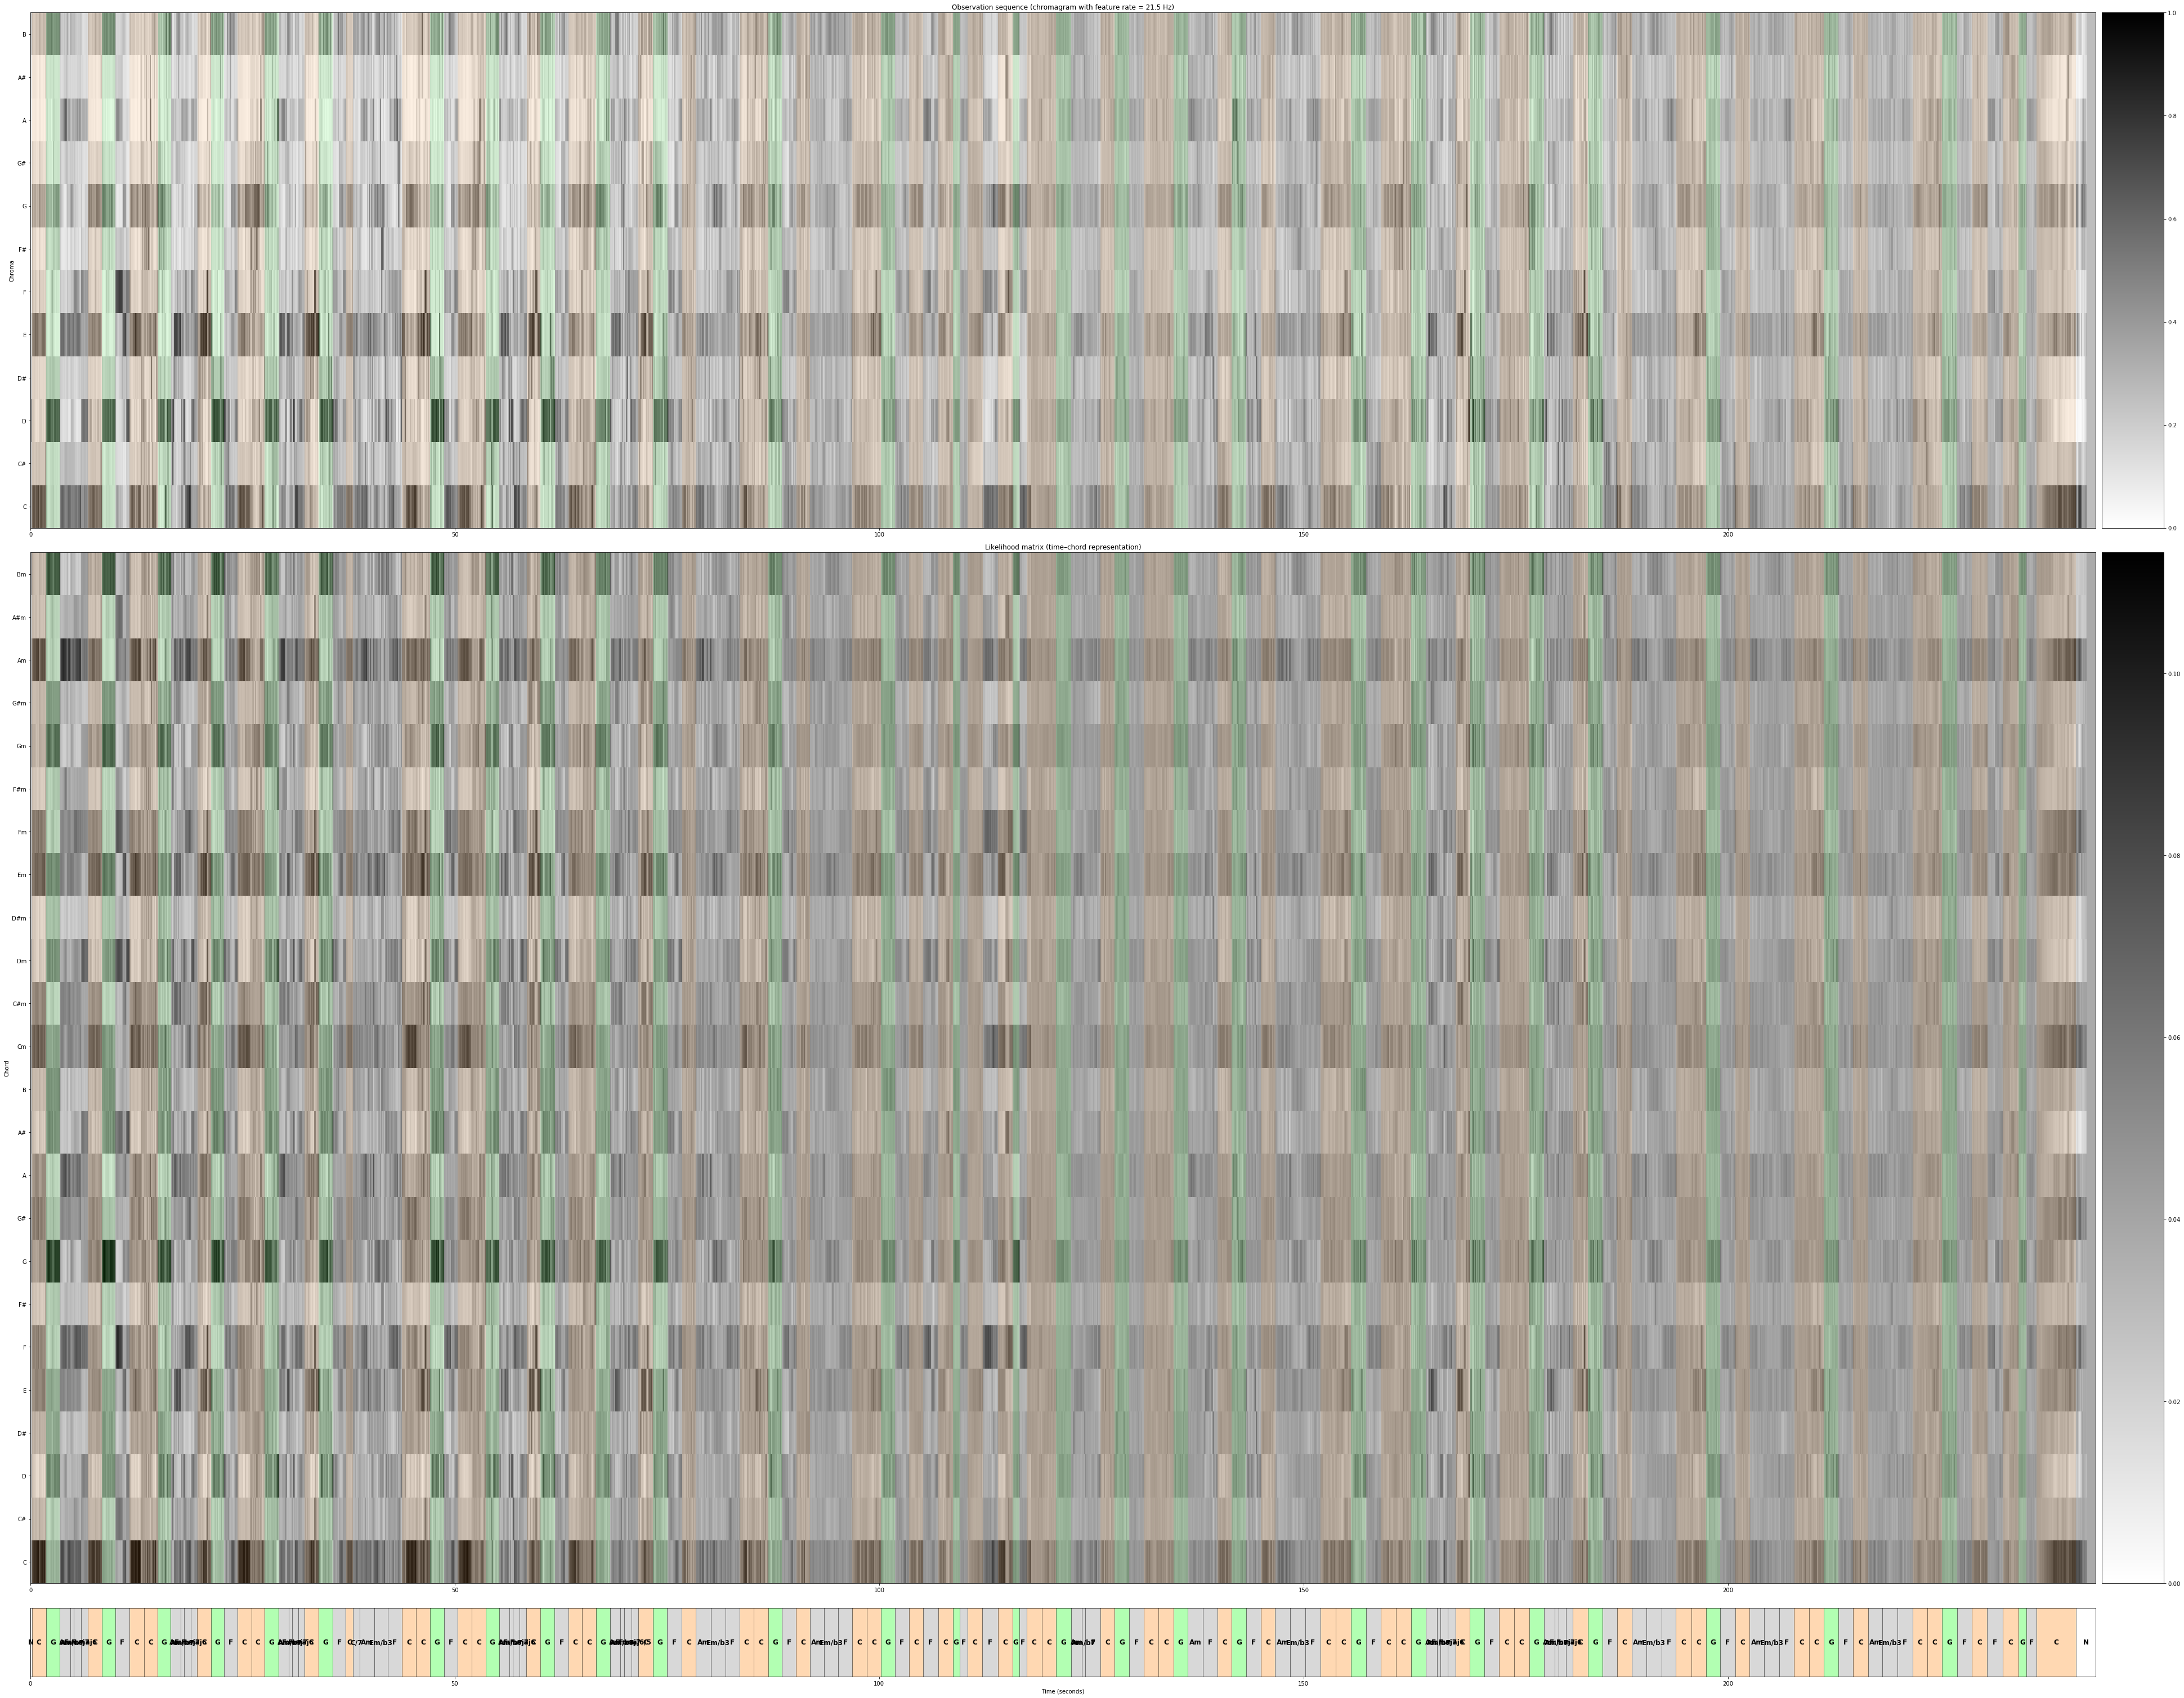

In [17]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.linalg import circulant
from numba import jit

import sys
sys.path.append('..')
import LibFMP.B
from LibFMP.C5 import get_chord_labels
%matplotlib inline


# Specify 
fn_wav = os.path.join('..', 'data', 'C5', 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06.wav')
fn_ann = os.path.join('..', 'data', 'C5', 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords.csv')
color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 'Dm': [1, 0, 0, 1], 'N': [1, 1, 1, 1]}

N = 4096
H = 1024
X, Fs_X, x, Fs, x_dur = \
    LibFMP.C5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
N_X = X.shape[1]

# Chord recogntion
chord_sim, chord_max = LibFMP.C5.chord_recognition_template(X, norm_sim='1')
chord_labels = LibFMP.C5.get_chord_labels(nonchord=False)

# Annotations
chord_labels = LibFMP.C5.get_chord_labels(ext_minor='m', nonchord=False)
ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = \
    LibFMP.C5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=True)
#P, R, F, TP, FP, FN = LibFMP.C5.compute_eval_measures(ann_matrix, chord_max)

# Plot
cmap = LibFMP.B.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 0.2]}, figsize=(54, 42))

LibFMP.B.plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='Observation sequence (chromagram with feature rate = %0.1f Hz)' % (Fs_X))
LibFMP.B.plot_segments_overlay(ann_seg_sec, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, clim=[0, np.max(chord_sim)],
                     title='Likelihood matrix (time–chord representation)',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange(len(chord_labels)))
ax[1, 0].set_yticklabels(chord_labels)
LibFMP.B.plot_segments_overlay(ann_seg_sec, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

LibFMP.B.plot_segments(ann_seg_sec, ax=ax[2, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[2,1].axis('off')
plt.tight_layout()

## Specification of Transition Probabilities

In music, certain chord transitions are more likely than others. This observation is our main motivation to employ [HMMs](../C5/C5S3_HiddenMarkovModel.html), where the first-order temporal relationships between the various chords can be captured by the **transition probability matrix** $A$. In the following, we use the notation $\alpha_{i}\rightarrow\alpha_{j}$ to refer to the transition from state $\alpha_{i}$ to state $\alpha_{j}$ for $i,j\in[1:I]$. For example, the coefficient $a_{1,2}$ expresses the probability for the transition $\alpha_{1}\rightarrow\alpha_{2}$ (corresponding to $\mathbf{C}\rightarrow\mathbf{C}^\sharp$), whereas $a_{1,8}$ expresses the probability for $\alpha_{1}\rightarrow\alpha_{8}$  (corresponding to  $\mathbf{C}\rightarrow\mathbf{G}$). In real music, the change from a tonic to the dominant is much more likely than changing by one semitone, so that the probability $a_{1,8}$ should be much larger than $a_{1,2}$. The coefficients $a_{i,i}$ express the probability of staying in state $\alpha_{i}$ (i.e., $\alpha_{i}\rightarrow\alpha_{i}$) for $i\in[1:I]$. These coefficients are also referred to as **self-transition** probabilities.

A transition probability matrix can be specified in many ways. For example, the matrix may be defined manually by a music expert based on rules from harmony theory. The most common approach is to generate such a matrix automatically 
by estimating the transition probabilities from labeled data. In the following figure, we show three different transition matrices (using a log probability scale for visualization purposes). 

* The first one was learned from labeled training data based on the [Beatles collection](../C5/C5S3_ChordRec_Beatles.html) using bigrams (pairs of adjacent elements) in the labeled frame sequences. As an example, the coefficient $a_{1,8}$ (corresponding to the transition $\mathbf{C}\rightarrow\mathbf{G}$) has been highlighted. 
* The second matrix is a **transposition-invariant** transition probability matrix obtained from the previous matrix. To achieve transposition invariance, the labeled training dataset is augmented by considering all twelve possible [cyclic chroma shifts](../C3/C3S1_TranspositionTuning.html) to the considered bigrams. 
* The third matrix is a **uniform** transition probability matrix with a large value on the main diagonal (self-transitions) and a much smaller value at all remaining positions. 

<img src="../data/C5/FMP_C5_F29-30-32.png" width="900px" align="left" alt="FMP_C5_F29-30-32">

<br clear="all" />

For more details on the construction of these transition matrices, we refer to Section 5.3.4.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. In the following code cell, we read a `CSV`-file that contains the precomputed transition matrix estimated on the basis of the [Beatles collection](../C5/C5S3_ChordRec_Beatles.html). In the visualization, we show both the probability values as well as the log-probability values. 

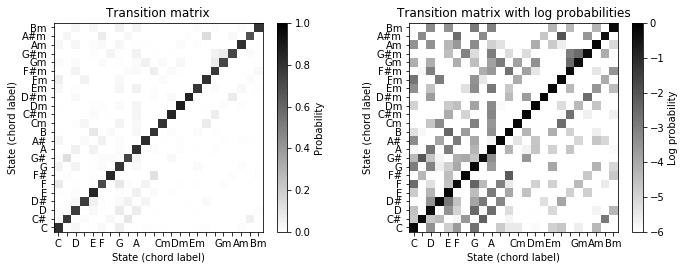

In [10]:
def plot_transition_matrix(A, log=True, ax=None, figsize=(6, 5), title='',
                           xlabel='State (chord label)', ylabel='State (chord label)',
                           cmap='gray_r', quadrant=False):
    """Plot a transition matrix for 24 chord models (12 major and 12 minor triads)

    Notebook: B/B_PythonVisualization.ipynb

    Args:
        A: Transition matrix
        ax: Axis
        figsize: Width, height in inches (only used when ax=None)
        title: Title for plot
        xlabel, ylabel: Label for x axis and y axis
        cmap: Color map
        quadrant: Plots additional lines for C-major and C-minor quadrants

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax = [ax]

    if log is True:
        A_plot = np.log(A)
        cbar_label = 'Log probability'
        clim = [-6, 0]
    else:
        A_plot = A
        cbar_label = 'Probability'
        clim = [0, 1]
    im = ax[0].imshow(A_plot, origin='lower', aspect='equal', cmap=cmap)
    im.set_clim(clim)
    plt.sca(ax[0])
    cbar = plt.colorbar(im)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    cbar.ax.set_ylabel(cbar_label)

    chord_labels = get_chord_labels()
    chord_labels_squeezed = chord_labels.copy()
    for k in [1, 3, 6, 8, 10, 11, 13, 15, 17, 18, 20, 22]:
        chord_labels_squeezed[k] = ''

    ax[0].set_xticks(np.arange(24))
    ax[0].set_yticks(np.arange(24))
    ax[0].set_xticklabels(chord_labels_squeezed)
    ax[0].set_yticklabels(chord_labels)

    if quadrant is True:
        ax[0].axvline(x=11.5, ymin=0, ymax=24, linewidth=2, color='r')
        ax[0].axhline(y=11.5, xmin=0, xmax=24, linewidth=2, color='r')

    return fig, ax, im

# Load transition matrix estimated on the basis of the Beatles collection
fn_csv = os.path.join('..', 'data', 'C5', 'FMP_C5_transitionMatrix_Beatles.csv')
A_est_df = pd.read_csv(fn_csv, delimiter=';')
A_est = A_est_df.to_numpy('float64')

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 
                                          'height_ratios': [1]}, 
                       figsize=(10, 3.8))

plot_transition_matrix(A_est, log=False, ax=[ax[0]], title='Transition matrix')
plot_transition_matrix(A_est, ax=[ax[1]], title='Transition matrix with log probabilities')
plt.tight_layout()

To obtain the **transposition-invariant transition matrix**, we simulate the [cyclic chroma shifts](../C3/C3S1_TranspositionTuning.html) on the matrix-level by cyclically shifting and averaging the four quadrants (defined by the major-chord and minor-chord regions) of the original matrix. In the visualization, we show the original transition matrix as well as the resulting transposition-invariant transition matrix. 

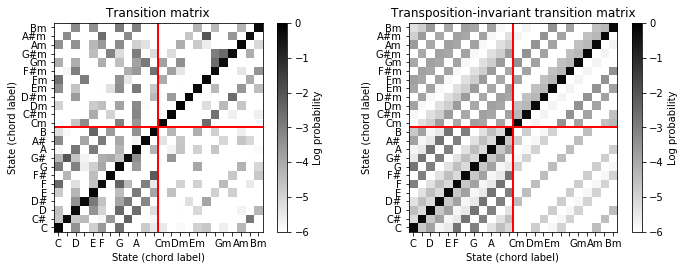

In [11]:
def matrix_circular_mean(A):
    """Computes circulant matrix with mean diagonal sums
    Notebook: C5/C5S3_ChordRec_HMM.ipynb

    Args:
        A: Square matrix

    Returns:
        A_mean: Circulant output matrix
    """
    N = A.shape[0]
    A_shear = np.zeros((N, N))
    for n in range(N):
        A_shear[:, n] = np.roll(A[:, n], -n)
    circ_sum = np.sum(A_shear, axis=1)
    A_mean = circulant(circ_sum) / N
    return A_mean
    
def matrix_chord24_trans_inv(A):
    """Computes transposition-invariant matrix for transition matrix
       based 12 major chords and 12 minor chords
       
    Notebook: C5/C5S3_ChordRec_HMM.ipynb
    
    Args:
        A: Input transition matrix 
    
    Returns:
        A_ti: Output transition matrix
    """    
    A_ti = np.zeros(A.shape)
    A_ti[0:12, 0:12] = matrix_circular_mean(A[0:12, 0:12])
    A_ti[0:12, 12:24] = matrix_circular_mean(A[0:12, 12:24])
    A_ti[12:24, 0:12] = matrix_circular_mean(A[12:24, 0:12])
    A_ti[12:24, 12:24] = matrix_circular_mean(A[12:24, 12:24])
    return A_ti


A_ti = matrix_chord24_trans_inv(A_est)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 
                                          'height_ratios': [1]}, 
                       figsize=(10, 3.8))

plot_transition_matrix(A_est, ax=[ax[0]], quadrant=True, 
                       title='Transition matrix')
plot_transition_matrix(A_ti, ax=[ax[1]], quadrant=True, 
                       title='Transposition-invariant transition matrix')
plt.tight_layout()

Finally, we provide a function for generating a uniform transition probability matrix. This function has a parameter $p\in[0,1]$ that determines the probability for self transitions (the value on the main diagonal). The probabilities on the remaining positions are set such that the resulting matrix is a probability matrix (i.e., all rows and columns sum to one).

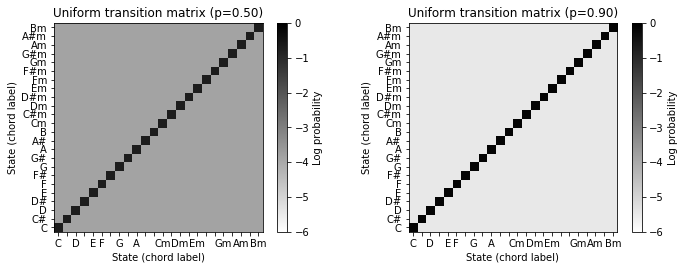

In [12]:
def uniform_transition_matrix(p=0.01, N=24):
    """Computes uniform transition matrix

    Notebook: C5/C5S3_ChordRec_HMM.ipynb

    Args:
        p: Self transition probability
        N: Column and row dimension

    Returns:
        A: Output transition matrix
    """
    off_diag_entries = (1-p) / (N-1)     # rows should sum up to 1
    A = off_diag_entries * np.ones([N, N])
    np.fill_diagonal(A, p)
    return A

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 
                                          'height_ratios': [1]}, 
                       figsize=(10, 3.8))

p = 0.5
A_uni = uniform_transition_matrix(p)
plot_transition_matrix(A_uni, ax=[ax[0]], title='Uniform transition matrix (p=%0.2f)' % p)
p = 0.9
A_uni = uniform_transition_matrix(p)
plot_transition_matrix(A_uni, ax=[ax[1]], title='Uniform transition matrix (p=%0.2f)' % p)
plt.tight_layout()

## HMM-Based Chord Recognition

As discussed before, the free parameters of the HMM-based model can either be learned automatically from the training set or set manually using musical knowledge. Continuing with our Bach example, we now present an experiment that demonstrates the effect of applying HMMs to our chord recognition scenario. We use the following setting:

* As observation sequence $O$, we use a sequence of chroma vectors.
* As for the transition probability matrix $A$, we simply use a uniform transition matrix. 
* As for the initial state probability vector $C$, we use a uniform distribution.
* As for the emission probability matrix $B$, we replace them by the likelihood matrix $B[O]$, which is a normalized version of the chord similarity matrix also used for the [template-based chord recognition](../C5/C5S2_ChordRec_Templates.html).
* The frame-wise chord recognition results is given by the state sequence computed by the [Viterbi algorithm](../C5/C5S3_Viterbi.html). 

Using the likelihood matrix $B[O]$ instead of emission probabilities requires a small modification of the original algorithm. In the following code cell, we provide the implementation of this modification using a numerically stable log version. We then compare the HMM-based results with the [template-based approach](../C5/C5S2_ChordRec_Templates.html) showing the [evaluation results in the form of time&ndash;chord visualizations](../C5/C5S2_ChordRec_Eval.html), respectively.

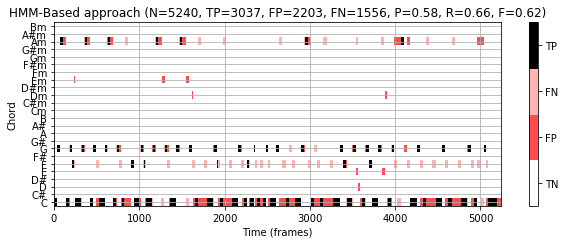

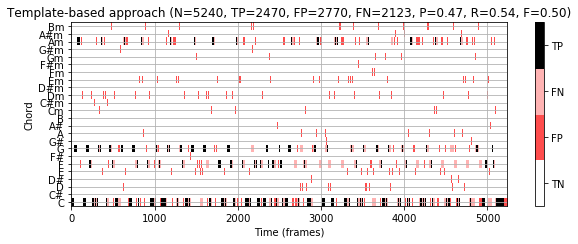

In [13]:
@jit(nopython=True)
def viterbi_log_likelihood(A, C, B_O):
    """Viterbi algorithm (log variant) for solving the uncovering problem

    Notebook: C5/C5S3_Viterbi.ipynb

    Args:
        A: State transition probability matrix of dimension I x I
        C: Initial state distribution  of dimension I
        B_O: Likelihood matrix of dimension I x N

    Returns:
        S_opt: Optimal state sequence of length N
        S_mat: Binary matrix representation of optimal state sequence
        D_log: Accumulated log probability matrix
        E: Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = B_O.shape[1]  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    A_log = np.log(A + tiny)
    C_log = np.log(C + tiny)
    B_O_log = np.log(B_O + tiny)

    # Initialize D and E matrices
    D_log = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D_log[:, 0] = C_log + B_O_log[:, 0]

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_sum = A_log[:, i] + D_log[:, n-1]
            D_log[i, n] = np.max(temp_sum) + B_O_log[i, n]
            E[i, n-1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N-2, 0, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    # Matrix representation of result
    S_mat = np.zeros((I, N)).astype(np.int32)
    for n in range(N):
        S_mat[S_opt[n], n] = 1

    return S_mat, S_opt, D_log, E

A = uniform_transition_matrix(p=0.5)
C = 1 / 24 * np.ones((1, 24))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

P, R, F, TP, FP, FN = LibFMP.C5.compute_eval_measures(ann_matrix, chord_HMM)
title = 'HMM-Based approach (N=%d, TP=%d, FP=%d, FN=%d, P=%.2f, R=%.2f, F=%.2f)' % (N_X, TP, FP, FN, P, R ,F)
fig, ax, im = LibFMP.C5.plot_matrix_chord_eval(ann_matrix, chord_HMM, Fs=1, 
                     title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)
plt.tight_layout()
plt.show()

P, R, F, TP, FP, FN = LibFMP.C5.compute_eval_measures(ann_matrix, chord_max)
title = 'Template-based approach (N=%d, TP=%d, FP=%d, FN=%d, P=%.2f, R=%.2f, F=%.2f)' %\
    (N_X, TP, FP, FN, P, R, F)
fig, ax, im = LibFMP.C5.plot_matrix_chord_eval(ann_matrix, chord_max, Fs=1, 
                     title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)
plt.tight_layout()
plt.show()

In this example, the HMM-based chord recognizer clearly outperforms the template-based approach. The improvements in HMM-based approach come specifically from the **transition model** that introduces context-sensitive smoothing. In the case of **high self-transition probabilities**, a chord recognizer tends to stay in the current chord rather than change to another one, which can be regarded as a kind of smoothing. This effect is also demonstrated in our Bach example, where the broken chords cause many [chord ambiguities](../C5/C5S2_ChordRec_Eval.html) of short duration. This leads to many random-like chord changes when using a simple template-based chord recognizer. Using an HMM-based approach, chord changes are only performed when the relatively low transition probabilities are compensated by a substantial increase of emission probabilities. Consequently, only the dominant chord changes remain.

## Prefiltering vs. Postfiltering

In the [FMP notebook on chord recognition evaluation](../C5/C5S2_ChordRec_Eval.html), we showed for the Bach example that one may achieve similar improvements by applying a longer window size when computing the input chromagram. Applying longer window sizes more or less amounts to temporal smoothing of the observation sequence. Since this smoothing is performed **prior** to the pattern matching step, we also call this strategy **prefiltering**. Note that such a prefiltering step not only smoothes out noise-like frames, but also washes out characteristic chroma information and blurs transitions. As opposed to prefiltering, the HMM-based approach leaves the feature representation untouched. Furthermore, the smoothing is performed in combination with the pattern matching step. For this reason, we also call this approach **postfiltering**. As a result, the original chroma information is preserved and transitions in the feature representation are kept sharp. 

<img src="../data/C5/FMP_C5_F13.png" width="500px" align="middle" alt="FMP_C5_F13">

## Further Notes

In this notebook, we introduced a basic HMM-based approach for chord recognition. In our simplistic model, we used $24$ states that correspond to the $12$ major and $12$ minor triads and fixed the HMM parameters explicitly using musical knowledge. 

* In the application to chord labeling, the HMM was then used to uncover the most likely chord labeling sequence that generates a given sequence of chroma features&mdash;an idea originally introduced by [Sheh and Ellis](https://www.ee.columbia.edu/~dpwe/pubs/ismir03-chords.pdf). 

* In general, there is a delicate interplay of the various feature extraction, filtering, and pattern matching components composing a chord recognition system. In this context, we refer to the excellent overview paper [On the Relative Importance of Individual Components of Chord Recognition Systems](https://ieeexplore.ieee.org/document/6691936) by Cho and Bello. 

* In the article [Analyzing Chroma Feature Types for Automated Chord Recognition](https://secure.aes.org/forum/pubs/conferences/?elib=15943) by Jiang et al., the importance of the input representation is investigated.

In this book, we have only considered a basic HMM variant. There are many more variants and extensions of HMMs including continuous HMMs and HMMs with specific state transition topologies. Rather than fixing the model parameters manually, the power of general HMMs is to automatically learn the free parameters based on training examples (e.g., using the [Baum-Welch Algorithm](../C5/C5S3_HiddenMarkovModel.html)). The estimation of the model parameters can become very intricate, leading to challenging and deep mathematical problems. For an excellent textbook on the classical theory of HMMs, including the discrete as well as the continuous case, we refer to the excellent book on [Hidden Markov Models for Speech Recognition](https://dl.acm.org/doi/book/10.5555/575447) by Huang et al. (1990). We close this notebook with an overview of a typical HMM-based chord recognition approach consisting of a training and an evaluation stage.

<img src="../data/C5/FMP_C5_F33.png" width="600px" align="center" alt="FMP_C5_F33.png">


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and  <a href="https://www.audiolabs-erlangen.de/fau/assistant/weiss">Christof Weiß</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>